## Test of handring categorical variables
- This notebook follows [GPyOpt test notebook](./GPyOpt_DAI_test_en.ipynb)

In [2]:
from GPyOpt.methods import BayesianOptimization
import os
import functools
import driverlessai
print(driverlessai.__version__)
import pandas as pd
import numpy as np

1.10.1.3


In [3]:
import json
with open('../idpass.json') as f:
    idpass = json.load(f)

In [4]:
# DAI Parameters
dai_url = 'http://54.159.88.206:12345'
dai_uname = idpass['id']
dai_password = idpass['pass11013']
#dai_experimet_key = '9b27f286-aca6-11ec-b964-0242ac110002'

# Optimization Parameters
acquisition_type = 'EI'    # 'EI', 'MPI', 'LCB'
constraints=None
maximize=True   # maximize=True：maximization problem, that is to minimize -f.  maximize=False：minimization problem
max_iter = 15
max_time = 600  # in seconds

In [5]:
dai = driverlessai.Client(address=dai_url, username=dai_uname, password=dai_password)

In [6]:
dai.experiments.list()

    | Type       | Key                                  | Name
----+------------+--------------------------------------+---------------------
  0 | Experiment | 575939ba-afc7-11ec-98cf-0242ac110002 | cc3-test
  1 | Experiment | 9b27f286-aca6-11ec-b964-0242ac110002 | uci-credit-reg-test
  2 | Experiment | bf5a9eba-9ea0-11ec-8908-0242ac110002 | dapawomu
  3 | Experiment | 69a5c178-9e9d-11ec-8908-0242ac110002 | bostonhouse-mod1
  4 | Experiment | 6dfccb46-9b86-11ec-8e63-0242ac110002 | wm-default

In [7]:
dai_experimet_key = '575939ba-afc7-11ec-98cf-0242ac110002'

experiment = dai.experiments.get(key=dai_experimet_key)

In [8]:
## Column info
dataset = dai.datasets.get(key=experiment.datasets['train_dataset'].key)
data_cols = dataset.columns
try:
    drop_cols = experiment.settings['drop_columns']     # return dropped column in list
except KeyError:
    drop_cols = []     # if no dropped column
target_col = experiment.settings['target_column']
x_cols = []
for col in data_cols:
    if (col in drop_cols) or (col in target_col):    # remove Target col and Dropped cols
        continue
    x_cols.append(col)

## Domain (Min and Max) of X columns and their types in training data
min_list = [col_summary.min for col_summary in dataset.column_summaries()[x_cols]]
max_list = [col_summary.max for col_summary in dataset.column_summaries()[x_cols]]
uniq_list = [col_summary.unique for col_summary in dataset.column_summaries()[x_cols]]
miss_list = [col_summary.missing>0 for col_summary in dataset.column_summaries()[x_cols]]
type_list = [col_summary.data_type for col_summary in dataset.column_summaries()[x_cols]]
type_list = pd.Series(type_list).map({'real':'continuous', 'int':'continuous', 'str':'categorical'})   # Map DAI data type to GPyOpt type
# GPyOpt takes 'continuous', 'discrete' or 'categorical'.
# 'categorical' is not tested in this notebook
df_domain = pd.DataFrame({'col':x_cols, 'min':min_list, 'max':max_list, 'unique':uniq_list, 'missing':miss_list, 'type':type_list})

In [9]:
df_domain

,col,min,max,unique,missing,type
0,SEX,NaN,NaN,2,False,categorical
1,EDUCATION,NaN,NaN,4,True,categorical
2,MARRIAGE,NaN,NaN,3,True,categorical
3,AGE,21.0,79.0,56,False,continuous
4,PAY_1,-2.0,8.0,11,False,continuous
5,PAY_2,-2.0,8.0,11,False,continuous
6,PAY_3,-2.0,8.0,11,False,continuous
7,PAY_4,-2.0,8.0,11,False,continuous
8,PAY_5,-2.0,8.0,10,False,continuous
9,PAY_6,-2.0,8.0,10,False,continuous


In [10]:
target_col

'LIMIT_BAL'

In [11]:
dataset.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
1,20000,M,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,True
2,120000,M,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,True
3,90000,M,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,False
4,50000,M,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,False
5,50000,F,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,False


In [12]:
bounds = []
for _, row in df_domain.iterrows():
    if row['type'] == 'continuous':
        bounds.append({'name':row['col'], 'type':row['type'], 'domain':(row['min'],row['max'])})
    else:
        if row['missing']:
            bounds.append({'name':row['col'], 'type':row['type'], 'domain':tuple(i for i in range(row['unique']+1))})   # missing is an one category
        else:
            bounds.append({'name':row['col'], 'type':row['type'], 'domain':tuple(i for i in range(row['unique']))})
bounds

[{'name': 'SEX', 'type': 'categorical', 'domain': (0, 1)},
 {'name': 'EDUCATION', 'type': 'categorical', 'domain': (0, 1, 2, 3, 4)},
 {'name': 'MARRIAGE', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
 {'name': 'AGE', 'type': 'continuous', 'domain': (21.0, 79.0)},
 {'name': 'PAY_1', 'type': 'continuous', 'domain': (-2.0, 8.0)},
 {'name': 'PAY_2', 'type': 'continuous', 'domain': (-2.0, 8.0)},
 {'name': 'PAY_3', 'type': 'continuous', 'domain': (-2.0, 8.0)},
 {'name': 'PAY_4', 'type': 'continuous', 'domain': (-2.0, 8.0)},
 {'name': 'PAY_5', 'type': 'continuous', 'domain': (-2.0, 8.0)},
 {'name': 'PAY_6', 'type': 'continuous', 'domain': (-2.0, 8.0)}]

In [13]:
# get all levels of categorical variables
dataset.download(dst_file='traindata.csv', overwrite=True)
traindata = pd.read_csv('traindata.csv')
categorical_cols = df_domain[df_domain['type']=='categorical']['col'].tolist()
categorical_levels = {}
for col in categorical_cols:
    categorical_levels[col] = traindata[col].unique().tolist()
if os.path.exists('traindata.csv'):
    os.remove('traindata.csv')

Downloaded 'traindata.csv'


In [14]:
categorical_levels

{'SEX': ['M', 'F'],
 'EDUCATION': ['university', 'graduate school', 'high school', nan, 'others'],
 'MARRIAGE': ['married', 'single', 'others', nan]}

In [24]:
def daimodel(x: np.array, dai: driverlessai._core.Client, experiment: driverlessai._experiments.Experiment, categorical_levels: dict) -> np.array:
    ''' 
    This function does DAI Scoring. And we want to find optimal x to minimize or maximize daimodel(x)
    Only regression model (classification model is not implemented)
    '''
    #print(type(x))
    #print(x.shape)
    #print(x)
    # Create a scoring data for DAI
    df = pd.DataFrame(np.array([x[:,i] for i in range(len(x_cols))]).reshape(x.shape[0], len(x_cols)), columns=x_cols)
    #print(df)
    for ccol, lv in categorical_levels.items():
        df[ccol] = lv[int(df[ccol])]    # in categorical cols, replace number to corresponding categorical value
    #print(df)
    # Upload it to DAI
    df.to_csv('tmp_pred.csv', index=False)
    data_to_predict = dai.datasets.create(data='./tmp_pred.csv', data_source='upload', name='tmp_pred.csv', force=True)
    # Scoring on the new dataset and download it
    dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
    data_to_predict.delete()
    # Download the scored data and return the prediction
    dai_predictions.download(dst_dir='', dst_file='tmp_res.csv', overwrite=True) 
    df_res = pd.read_csv('tmp_res.csv')
    print('---------- Done ----------')
    return np.array(df_res[experiment.settings['target_column']])    # return only prediction

daimodel_gpyopt = functools.partial(daimodel, dai=dai, experiment=experiment, categorical_levels=categorical_levels)

In [17]:
# run Baysian optimization
myBopt = BayesianOptimization(f=daimodel_gpyopt, 
                              domain=bounds, 
                              acquisition_type=acquisition_type,
                              #batch_size=4,
                              #num_cores=4,
                              # ToDo: constraints. Can set constraints such as x1+x2+x3=1
                              constraints=constraints, 
                              maximize=maximize)

myBopt.run_optimization(max_iter=max_iter, max_time=max_time)

Complete 100.00% - [4/4] Computed stats for column PAY_6
Complete
Driverless AI Server reported dataset 66e689b0-b0ac-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_6
Complete
Driverless AI Server reported dataset 6b48d2c4-b0ac-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_6
Complete
Driverless AI Server reported dataset 6f8b7328-b0ac-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_6
Complete
Driverless AI Server reported dataset 73d49914-b0ac-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column PAY_6
Complete
Driverless AI Server reported dataset 7822d95e-b0ac-11ec-866d-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done -

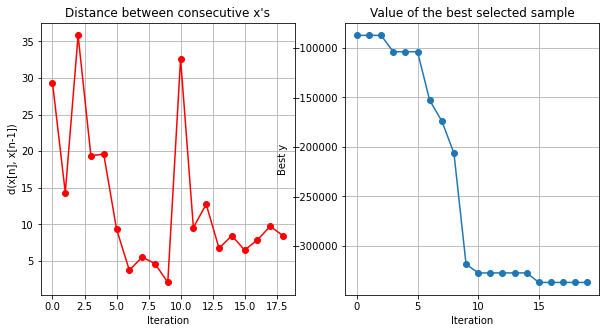

In [18]:
# Optimization history
myBopt.plot_convergence()

In [19]:
opt_history = pd.DataFrame(myBopt.X, columns=x_cols).join(pd.DataFrame(myBopt.Y, columns=[target_col]))
opt_history

,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL
0,0.0,3.0,2.0,52.143136,-1.124472,-0.464030,4.047404,7.622522,7.193965,5.950469,-87234.040
1,0.0,2.0,2.0,25.048274,-0.538007,7.511255,-1.880793,2.562817,6.701361,4.322292,-67900.170
2,1.0,4.0,1.0,21.854182,1.596095,-0.101504,6.312920,6.143387,-0.045552,2.989539,-48757.227
3,1.0,4.0,2.0,56.747061,5.627198,0.286659,-0.400862,4.532264,0.118665,3.608621,-103783.540
4,0.0,2.0,2.0,40.490686,4.305786,-0.623306,6.904654,1.145977,4.961898,-0.295568,-103570.490
5,1.0,4.0,2.0,57.173227,5.998363,0.391185,-0.198369,4.353837,0.271714,3.486928,-100755.640
6,1.0,4.0,2.0,48.570319,5.186809,-0.934026,0.435927,2.364130,-0.950878,1.105819,-152796.500
7,1.0,4.0,2.0,46.906503,4.737811,-2.000000,-2.000000,1.395205,-2.000000,-0.301450,-173786.250
8,1.0,4.0,2.0,46.482582,0.728919,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-206201.230
9,1.0,1.0,0.0,47.590724,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-318497.300


In [20]:
def replace_categorical_cols_elements(df: pd.DataFrame, categorical_levels_dict: dict) -> pd.DataFrame:
    ''' replacing categorical column's index to corresponding string value
    '''
    for c, l in categorical_levels_dict.items():
        df[c] = [l[int(i)] for i in df[c]]
    return df

In [21]:
replace_categorical_cols_elements(opt_history, categorical_levels)

,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL
0,M,NaN,others,52.143136,-1.124472,-0.464030,4.047404,7.622522,7.193965,5.950469,-87234.040
1,M,high school,others,25.048274,-0.538007,7.511255,-1.880793,2.562817,6.701361,4.322292,-67900.170
2,F,others,single,21.854182,1.596095,-0.101504,6.312920,6.143387,-0.045552,2.989539,-48757.227
3,F,others,others,56.747061,5.627198,0.286659,-0.400862,4.532264,0.118665,3.608621,-103783.540
4,M,high school,others,40.490686,4.305786,-0.623306,6.904654,1.145977,4.961898,-0.295568,-103570.490
5,F,others,others,57.173227,5.998363,0.391185,-0.198369,4.353837,0.271714,3.486928,-100755.640
6,F,others,others,48.570319,5.186809,-0.934026,0.435927,2.364130,-0.950878,1.105819,-152796.500
7,F,others,others,46.906503,4.737811,-2.000000,-2.000000,1.395205,-2.000000,-0.301450,-173786.250
8,F,others,others,46.482582,0.728919,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-206201.230
9,F,graduate school,married,47.590724,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-318497.300


In [22]:
opt_x = pd.DataFrame(myBopt.x_opt.reshape(1,len(x_cols)), columns=x_cols)
replace_categorical_cols_elements(opt_x, categorical_levels)

,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,F,graduate school,married,79.0,-2.0,-2.0,8.0,-2.0,-0.255138,4.838993


In [23]:
myBopt.fx_opt

-336936.3